In [384]:
%reset -f

In [385]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
import time
import kl_ucb_policy

In [386]:
class TSBanditPolicy :
    """
    Thompson Sampling Bandit
    """
    def __init__(self, K, rate, Delta):
        self.K = K
        self.rate = rate
        self.delta = Delta # packet error rate (PER) threshold
        self.reset()

    def reset(self):
        self.a = np.ones(self.K) # success number for each rate
        self.b = np.ones(self.K) # failure number for each rate

    def select_next_arm(self):
        p = beta.rvs(self.a, self.b) # estimated PER
        p_avail = p.copy()*(p>self.delta) # available rates with PER larger than delta
        if sum(p_avail) != 0:
            selected_arm = np.argmax(np.multiply(p_avail,self.rate))
        else:
            selected_arm = np.argmax(p)
        # print('indices are: ', indices)
        return selected_arm

    def update_state(self, k, r):
        self.a[k] += r # update success number for selected rate k
        self.b[k] += (1-r) # update failure number for selected rate k

In [387]:
class CBanditPolicy(TSBanditPolicy):
    """
    Correlated Bandit based on Thompson Sampling
    """
    def __init__(self, K, rate, s, delta):
        super().__init__(K, rate, delta)
        self.s = s # conditional upper bound matrix [[K,K],[K,K]]
        self.reset()

    def reset(self):
        super().reset()
        self.A = np.zeros(self.K)
        self.Phi = np.zeros([K,K]) # expected pseudo-rewards

    def reduce_set(self):
        # n = self.a + self.b - 2*self.K # selected times for each arm
        # t = sum(n) # total time
        # self.Sig_S = np.zeros(self.K)
        # self.Sig_S += (n>=t/self.K) # a boolean array, 1 indicating significant rate, 0 indicating insignificant rate
        # r_emp = (beta.rvs(self.a, self.b)*self.rate)*self.Sig_S
        r_emp = beta.rvs(self.a, self.b)*self.rate
        lead = np.argmax(r_emp) # leading arm in significant set
        mu_lead = r_emp[lead]

        # self.A = np.zeros(self.K) # competitive set, a boolean array. 1 indicating competitive rate, 0 indicating non-competitive rate
        # for k in range(self.K):
        #     phi_tmp =self.Sig_S*self.Phi[k,:]
        #     if np.min(phi_tmp) >= mu_lead:
        #         self.A[k] = 1
        # self.A[lead] = 1
        for k in range(self.K):
            if np.min(self.Phi[k,:]) >= mu_lead:
                self.A[k] = 1

    def select_next_arm(self):
        t = sum(self.a+self.b) - 2*self.K
        if t <= K-1:
            print('initialize t', t)
            return int(t)
        p = beta.rvs(self.a, self.b) # estimated PER
        p_comp = p.copy()*self.A # competitive rates
        selected_arm = np.argmax(np.multiply(p_comp,self.rate))
        # print('indices are: ', indices)
        return selected_arm

    def update_state(self, k, r):
        # print('the reward is', r)
        self.a[k] += r # update success number for selected rate k
        self.b[k] += (1-r) # update failure number for selected rate k
        n = self.a[k] + self.b[k] - 2
        for l in range(K):
            self.Phi[l,k] = ((n-1)*self.Phi[l,k]+self.s[r][l,k])/n # update pseudo-rewards
        # for k in range(K):
        #     self.Phi[k,k] = beta.rvs(self.a[k],self.b[k])*rate[k]

In [388]:
def construct_s(rate, K):
    s = []
    s.append(np.zeros([K,K]))
    s.append(np.zeros([K,K]))
    for k in range(K):
        for l in range(K):
            if rate[l] < rate[k]:
                s[0][l,k] = rate[l]
            else:
                s[0][l,k] = 0
    for k in range(K):
        for l in range(K):
            s[1][l,k] = rate[l]
    return s

In [389]:
class TSBandit_SW(TSBanditPolicy):
    """
    TS_Bandit with Sliding Window
    """
    def __init__(self, K, rate, Delta, tau):
        super().__init__(K, rate, Delta)
        self.tau = tau # window size

    def reset(self):
        self.a_window = [[] for i in range(self.K)] # sliding window for success number of each rate, [K,tau] matrix
        self.b_window = [[] for i in range(self.K)] # sliding window for failure number of each rate, [K, tau] matrix
        self.a = np.zeros(self.K)
        self.b = np.zeros(self.K)

    def update_state(self, k, r):
        if len(self.a_window[k]) == self.tau:
            self.a_window[k].pop(0)
            self.a_window[k].append(r)
            self.b_window[k].pop(0)
            self.b_window[k].append(1-r)
        else:
            self.a_window[k].append(r)
            self.b_window[k].append(1-r)
        self.a[k] = sum(self.a_window[k]) # alpha is the sum of success numer in the window
        self.b[k] = sum(self.b_window[k]) # beta is the sum of failure number in the window

In [390]:
#Parameters for TS test
p = np.array([.99, .98, .96, .93, .90, .10, .06, .04]) #Bernoulli Parameters
# p = np.array([.95, .90, .80, .65, .45, .25, .15, .10])
# p = np.array([.90, .80, .70, .55, .45, .35, .20, .10])
rate = np.array([6, 9, 12, 18, 24, 36, 48, 54])
tp = np.multiply(p,rate)

K= p.shape[0] #Number of branches
Delta= ( np.ones(K)*np.max(tp) ) - tp
s = construct_s(rate, K)


T= 5000 #Time periods
runs = 1 #Number of iterations

print("Pi:",p)
print("Delta:",Delta)

Pi: [0.99 0.98 0.96 0.93 0.9  0.1  0.06 0.04]
Delta: [15.66 12.78 10.08  4.86  0.   18.   18.72 19.44]


## Thompson Sampling Bandit Simulation

In [391]:
# %%capture
ts = CBanditPolicy(K, rate, s, 0)
total_rewards_list_ts = np.zeros((runs, T))
actions_list_ts = []

klucb = kl_ucb_policy.KLUCBPolicy(K, rate) #Original KL UCB
total_rewards_list_klucb = np.zeros((runs, T))
actions_list_klucb = []

start_time = time.time()

for run in range(runs):
    ts.reset()
    actions_ts = np.zeros((K, T), dtype=np.int)
    rewards_ts = np.zeros((K, T), dtype=np.float)

    klucb.reset()
    actions_klucb = np.zeros((K, T), dtype=np.int)
    rewards_klucb = np.zeros((K, T), dtype=np.float)
    for t in range(T):
        ts.reduce_set()
        arm_ts = ts.select_next_arm()
        # print('selected arm is', arm_ts)
        actions_ts[arm_ts, t] = 1
        rewards_ts[arm_ts, t] = np.random.binomial(1, p[arm_ts]) * rate[arm_ts]
        ts.update_state(arm_ts, int(rewards_ts[arm_ts, t] / rate[arm_ts]))

        arm_klucb = klucb.select_next_arm()
        actions_klucb[arm_klucb, t] = 1
        rewards_klucb[arm_klucb, t] = np.random.binomial(1, p[arm_klucb]) * rate[arm_klucb]
        klucb.update_state(arm_klucb, rewards_klucb[arm_klucb, t] / rate[arm_klucb])

    cumulative_rewards_ts = np.cumsum(rewards_ts, axis=1) #Cumulative rewards of each arm according to time
    total_rewards_ts = np.sum(cumulative_rewards_ts, axis=0) #Cumulative rewards of all arms according to time
    total_rewards_list_ts[run, :] = np.copy(total_rewards_ts)
    actions_list_ts.append(np.copy(actions_ts))

    cumulative_rewards_klucb = np.cumsum(rewards_klucb, axis=1) #Cumulative rewards of each arm according to time
    total_rewards_klucb = np.sum(cumulative_rewards_klucb, axis=0) #Cumulative rewards of all arms according to time
    total_rewards_list_klucb[run, :] = np.copy(total_rewards_klucb)
    actions_list_klucb.append(np.copy(actions_klucb))

time_spent = time.time() - start_time

initialize t 0.0
initialize t 1.0
initialize t 2.0
initialize t 3.0
initialize t 4.0
initialize t 5.0
initialize t 6.0
initialize t 7.0


C:\Users\Jarvis\AppData\Local\Temp\ipykernel_7260\1389708094.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  actions_ts = np.zeros((K, T), dtype=np.int)
C:\Users\Jarvis\AppData\Local\Temp\ipykernel_7260\1389708094.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org

## Simulation Result

Time for Thompson Sampling, with T = 5000 , runs = 1 : 3.080695629119873 seconds
t & Reward (total) TS : 4999 107661.0
t & Reward (total) KL-UCB : 4999 104598.0


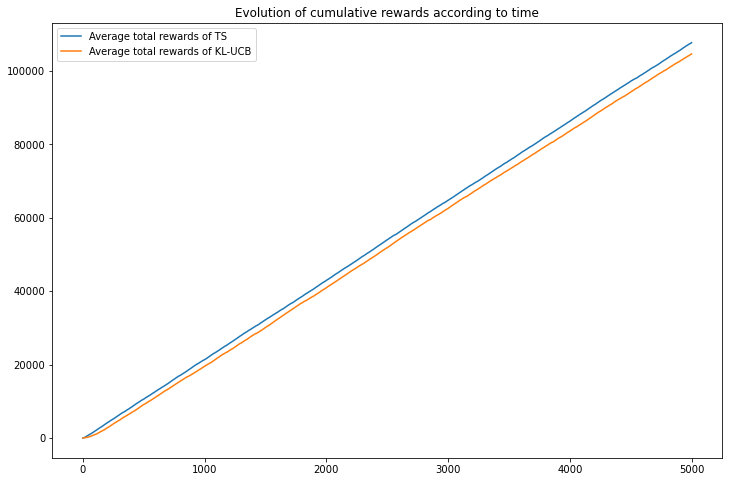

In [392]:
print("Time for Thompson Sampling, with T =", T, ", runs =", runs, ":", (time_spent), "seconds")

## Average total rewards
mean_total_rewards_ts = np.mean(total_rewards_list_ts, axis=0)
mean_total_rewards_klucb = np.mean(total_rewards_list_klucb, axis=0)
print("t & Reward (total) TS :", t, mean_total_rewards_ts[t])
print("t & Reward (total) KL-UCB :", t, mean_total_rewards_klucb[t])

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(mean_total_rewards_ts, linestyle='-', label='Average total rewards of TS')
ax1.plot(mean_total_rewards_klucb, linestyle='-', label='Average total rewards of KL-UCB')
ax1.legend(loc='best')
ax1.set_title('Evolution of cumulative rewards according to time')
plt.show()

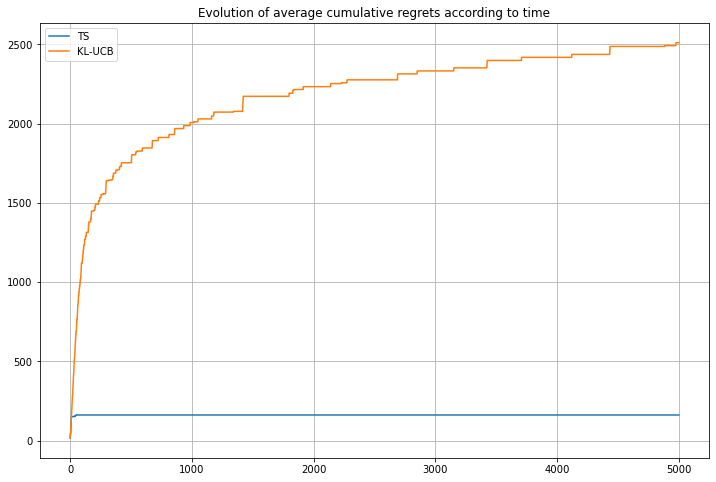

In [393]:
#Regrets calculation for TS
total_action_ts = np.zeros((K, T))
for actions_ts in actions_list_ts:
    total_action_ts += np.cumsum(actions_ts, axis=1)  #The cumulative times of each arm to be selected
total_action_ts = total_action_ts / runs
regret_cumule_ts = np.dot(Delta, total_action_ts[:, :])  # Cumulative regrets

total_action_klucb = np.zeros((K, T))
for actions_klucb in actions_list_klucb:
    total_action_klucb += np.cumsum(actions_klucb, axis=1) #The cumulative times of each arm to be selected
total_action_klucb = total_action_klucb / runs
regret_cumule_klucb = np.dot(Delta, total_action_klucb[:, :]) # Cumulative regrets

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(regret_cumule_ts[:], linestyle='-', label='TS')
ax1.plot(regret_cumule_klucb[:],linestyle='-', label='KL-UCB')

ax1.legend(loc='best')
ax1.grid()
ax1.set_title('Evolution of average cumulative regrets according to time')
#ax1.xscale('log')
plt.show()